In [4]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.stats import zscore
# # step one, dannce alignment
import os
import sys
sys.path.append(os.path.abspath('../..'))

def load_filtered_data_from_h5(h5_file_path):
    """
    Loads the 'filtered_data' group from an HDF5 file into a Pandas DataFrame.
    """
    with h5py.File(h5_file_path, "r") as hf:
        # Access the group where the DataFrame columns were saved
        grp = hf["filtered_data"]
        
        # Each dataset in 'grp' is a column; read them into a dict of numpy arrays
        data_dict = {}
        for col_name in grp.keys():
            # Read dataset
            col_data = grp[col_name][:]
            
            # If it's a string dataset, h5py might already give you Python strings,
            # but just to be safe, handle bytes if encountered
            if col_data.dtype.kind in ["S", "O"] or isinstance(col_data.flatten()[0], bytes):
                col_data = [elem.decode("utf-8") if isinstance(elem, bytes) else elem 
                            for elem in col_data]
            
            data_dict[col_name] = col_data
        
    # Create a DataFrame from the data dictionary
    df = pd.DataFrame(data_dict)
    return df

import matplotlib.pyplot as plt
import numpy as np

def plot_cluster_timeline_from_df(df):
    """
    Plots a timeline of clusters per Prediction_path using 'Cluster' and 'frame' columns.
    If 'frame' doesn't exist, it falls back to 'n_frames', then finally falls back to an index.
    """
    unique_paths = df['Prediction_path'].unique()
    
    for path in unique_paths:
        # Filter data for this path
        path_data = df[df['Prediction_path'] == path]
        
        # 1) Prefer 'frame' if it exists; it's likely the actual, larger frame index.
        # 2) If not present, try 'n_frames'.
        # 3) Otherwise, fallback to a simple 0..N-1 index.
        if 'frame' in path_data.columns:
            frames = path_data['frame'].values
        elif 'n_frames' in path_data.columns:
            frames = path_data['n_frames'].values
        else:
            frames = np.arange(len(path_data))
        
        # Make sure 'Cluster' exists
        if 'Cluster' not in path_data.columns:
            print(f"Warning: 'Cluster' column not found for path '{path}', skipping.")
            continue
        clusters = path_data['Cluster'].values
        
        # Map clusters to numeric if they're not already
        if not np.issubdtype(clusters.dtype, np.number):
            unique_str_clusters = list(np.unique(clusters))
            cluster_idx_map = {val: i for i, val in enumerate(unique_str_clusters)}
            clusters_numeric = [cluster_idx_map[c] for c in clusters]
            clusters = np.array(clusters_numeric)
        
        # Create a colormap for clusters
        unique_clusters = np.unique(clusters)
        norm = plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))
        cluster_colors = plt.cm.tab10(norm(clusters))
        
        # Plot
        plt.figure(figsize=(10, 2))
        scatter = plt.scatter(frames, np.zeros_like(frames), c=cluster_colors, 
                              marker='|', s=200)
        plt.title(f"Cluster Timeline for Prediction Path: {path}")
        plt.xlabel("Frames (Temporal Axis)")
        plt.yticks([])  # Hide Y-axis since it's not meaningful here

        
        # Save and show
        plt.savefig(f"{path}_cluster_timeline.png", dpi=150)
        plt.show()


def plot_cluster_timeline_from_df(df, time_index=None):
    unique_paths = df['Prediction_path'].unique()
    
    for path in unique_paths:
        path_data = df[df['Prediction_path'] == path]
        
        # Step 1: Identify frames
        if 'frame' in path_data.columns:
            frames = path_data['frame'].values
        elif 'n_frames' in path_data.columns:
            frames = path_data['n_frames'].values
        else:
            frames = np.arange(len(path_data))
        
        # Step 2: Get the clusters
        if 'Cluster' not in path_data.columns:
            print(f"Warning: 'Cluster' column not found for path '{path}', skipping.")
            continue
        clusters = path_data['Cluster'].values
        
        # If clusters are strings, map them to numeric
        if not np.issubdtype(clusters.dtype, np.number):
            unique_str_clusters = np.unique(clusters)
            cluster_idx_map = {val: i for i, val in enumerate(unique_str_clusters)}
            clusters_numeric = [cluster_idx_map[c] for c in clusters]
            clusters = np.array(clusters_numeric)
        
        # Step 3: If we have time_index, convert frames -> actual timestamps
        if time_index is not None:
            frames = frames.astype(int)
            valid_mask = (frames >= 0) & (frames < len(time_index))
            # Use the same mask for frames AND clusters <==
            frames_valid = frames[valid_mask]
            clusters_valid = clusters[valid_mask]  # <== also apply mask here
            plot_x = time_index[frames_valid]      # actual timestamps
        else:
            # If no time_index, just use frames as numeric x-axis
            frames_valid = frames
            clusters_valid = clusters
            plot_x = frames_valid
        
        # Step 4: Create colors for the valid clusters only
        unique_clusters = np.unique(clusters_valid)
        norm = plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))
        
        # cluster_colors must be same length as clusters_valid
        cluster_colors_valid = plt.cm.tab10(norm(clusters_valid))  # <== also masked
        
        # Step 5: Plot
        plt.figure(figsize=(10, 2))
        plt.scatter(plot_x, np.zeros_like(plot_x), 
                    c=cluster_colors_valid,  # <== same length as plot_x
                    marker='|', s=200)
        
        plt.title(f"Cluster Timeline for Prediction Path: {path}")
        if time_index is not None:
            plt.xlabel("Time (from df_new.index)")
        else:
            plt.xlabel("Frames (Temporal Axis)")
        plt.yticks([])
        plt.tight_layout()
        
        # Save and show
        plt.savefig(f"{path}_cluster_timeline.png", dpi=150)
        plt.show()


def plot_behavior_timeline(df, cluster_behavior_map, time_index=None):
    """
    Plots behavior-specific timelines using clusters mapped to behaviors.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing cluster and frame information.
        cluster_behavior_map (dict): Dictionary mapping clusters to behaviors.
        time_index (np.array or None): Array of timestamps for each frame (optional).
    """
    unique_paths = df['Prediction_path'].unique()

    for path in unique_paths:
        path_data = df[df['Prediction_path'] == path]

        # Identify frames
        if 'frame' in path_data.columns:
            frames = path_data['frame'].values
        elif 'n_frames' in path_data.columns:
            frames = path_data['n_frames'].values
        else:
            frames = np.arange(len(path_data))

        # Map clusters to behaviors
        behaviors = path_data['Cluster'].map(cluster_behavior_map)
        if behaviors.isnull().all():
            print(f"No behaviors mapped for path '{path}', skipping.")
            continue

        # If time_index provided, map frames to timestamps
        if time_index is not None:
            frames = frames.astype(int)
            valid_mask = (frames >= 0) & (frames < len(time_index))
            frames = frames[valid_mask]
            behaviors = behaviors[valid_mask]
            plot_x = time_index[frames]
        else:
            plot_x = frames

        # Plot each behavior separately
        unique_behaviors = behaviors.dropna().unique()
        plt.figure(figsize=(10, len(unique_behaviors) * 2))

        for i, behavior in enumerate(unique_behaviors):
            behavior_mask = behaviors == behavior
            plt.scatter(plot_x[behavior_mask], np.full_like(plot_x[behavior_mask], i),
                        label=behavior, s=50, marker='|')

        plt.title(f"Behavior Timeline for Prediction Path: {path}")
        if time_index is not None:
            plt.xlabel("Time (s)")
        else:
            plt.xlabel("Frames")
        plt.yticks(range(len(unique_behaviors)), unique_behaviors)
        plt.legend(loc="upper right", fontsize=8)
        plt.tight_layout()

        # Save and show
        plt.savefig(f"{path}_behavior_timeline.png", dpi=150)
        plt.show()


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list

# %matplotlib inline  # Uncomment in Jupyter notebooks

# def plot_cluster_timeline_on_axes(ax, df, time_index=None):
#     """
#     Plots cluster timeline on a provided Axes object (ax), 
#     aligned with time_index if given.
#     """
#     unique_paths = df['Prediction_path'].unique()
    
#     for path in unique_paths:
#         path_data = df[df['Prediction_path'] == path]
        
#         # Step 1: Identify frames
#         if 'frame' in path_data.columns:
#             frames = path_data['frame'].values
#         elif 'n_frames' in path_data.columns:
#             frames = path_data['n_frames'].values
#         else:
#             frames = np.arange(len(path_data))
        
#         # Step 2: Get the clusters
#         if 'Cluster' not in path_data.columns:
#             print(f"Warning: 'Cluster' column not found for path '{path}', skipping.")
#             continue
#         clusters = path_data['Cluster'].values
        
#         # Convert string clusters to numeric if needed
#         if not np.issubdtype(clusters.dtype, np.number):
#             unique_str_clusters = np.unique(clusters)
#             cluster_idx_map = {val: i for i, val in enumerate(unique_str_clusters)}
#             clusters_numeric = [cluster_idx_map[c] for c in clusters]
#             clusters = np.array(clusters_numeric)
        
#         # Step 3: Map frames -> timestamps if time_index is provided
#         if time_index is not None:
#             frames = frames.astype(int)
#             valid_mask = (frames >= 0) & (frames < len(time_index))
#             frames_valid = frames[valid_mask]
#             clusters_valid = clusters[valid_mask]
#             plot_x = time_index[frames_valid]  # actual timestamps
#         else:
#             frames_valid = frames
#             clusters_valid = clusters
#             plot_x = frames_valid
        
#         # Step 4: Create colors for the valid clusters
#         unique_clusters = np.unique(clusters_valid)
#         norm = plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))
#         cluster_colors_valid = plt.cm.tab10(norm(clusters_valid))
        
#         # Step 5: Plot on the provided Axes
#         ax.scatter(plot_x, np.zeros_like(plot_x), 
#                    c=cluster_colors_valid, marker='|', s=200, label=path)
    
#     # Some cosmetic fixes
#     ax.set_title("Cluster Timeline")
#     # if time_index is not None:
#     #     ax.set_xlabel("Time (from df_new.index)")
#     # else:
#     #     ax.set_xlabel("Frames (Temporal Axis)")
#     # ax.set_yticks([])
#     # ax.legend(loc='upper right', bbox_to_anchor=(1.18, 1.0))  # Adjust as needed
def plot_cluster_timeline_on_axes(ax, df, time_index=None, behavior_labels=None):
    """
    Plots cluster timeline on a provided Axes object (ax),
    aligned with time_index if given, and colored by behavior labels if provided.
    
    Parameters:
        ax: Matplotlib Axes object.
        df: DataFrame containing 'Prediction_path', 'Cluster', and 'frame' or 'n_frames'.
        time_index: (Optional) Time index to map frames to timestamps.
        behavior_labels: (Optional) Dictionary mapping clusters to behaviors (e.g., {1: 'Grooming'}).
    """
    unique_paths = df['Prediction_path'].unique()

    # Default colormap
    cmap = plt.cm.tab10
    cluster_colors = {}
    
    # Prepare behavior-specific colors if labels are provided
    if behavior_labels:
        unique_behaviors = set(behavior_labels.values())
        behavior_colors = {behavior: cmap(i) for i, behavior in enumerate(unique_behaviors)}
        for cluster, behavior in behavior_labels.items():
            cluster_colors[cluster] = behavior_colors[behavior]

    for path in unique_paths:
        path_data = df[df['Prediction_path'] == path]
        
        # Identify frames
        if 'frame' in path_data.columns:
            frames = path_data['frame'].values
        elif 'n_frames' in path_data.columns:
            frames = path_data['n_frames'].values
        else:
            frames = np.arange(len(path_data))
        
        # Get clusters
        if 'Cluster' not in path_data.columns:
            print(f"Warning: 'Cluster' column not found for path '{path}', skipping.")
            continue
        clusters = path_data['Cluster'].values
        
        # Convert string clusters to numeric if needed
        if not np.issubdtype(clusters.dtype, np.number):
            unique_str_clusters = np.unique(clusters)
            cluster_idx_map = {val: i for i, val in enumerate(unique_str_clusters)}
            clusters_numeric = [cluster_idx_map[c] for c in clusters]
            clusters = np.array(clusters_numeric)
        
        # Map frames -> timestamps if time_index is provided
        if time_index is not None:
            frames = frames.astype(int)
            valid_mask = (frames >= 0) & (frames < len(time_index))
            frames_valid = frames[valid_mask]
            clusters_valid = clusters[valid_mask]
            plot_x = time_index[frames_valid]  # Actual timestamps
        else:
            frames_valid = frames
            clusters_valid = clusters
            plot_x = frames_valid
        
        # Map clusters to colors
        if behavior_labels:
            colors = [cluster_colors.get(cluster, 'gray') for cluster in clusters_valid]
        else:
            unique_clusters = np.unique(clusters_valid)
            norm = plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))
            colors = plt.cm.tab10(norm(clusters_valid))
        
        # Plot on the provided Axes
        ax.scatter(plot_x, np.zeros_like(plot_x), 
                   c=colors, marker='|', s=200, label=path)
    
    # Cosmetic fixes
    ax.set_title("Cluster Timeline by Behavior")
    ax.set_yticks([])
    if behavior_labels:
        ax.legend(handles=[plt.Line2D([0], [0], color=color, marker='|', 
                                       markersize=10, label=behavior, linestyle='None') 
                           for behavior, color in behavior_colors.items()],
                  loc='upper right', bbox_to_anchor=(1.2, 1.0))  # Adjust as needed

In [5]:
# -------------------------------------------------------------------
# 3) Example usage with filtered_df (loaded from HDF5)
#    You already have a function for that, e.g. load_filtered_data_from_h5
# -------------------------------------------------------------------
aligned_dappy_path = "/home/lq53/mir_repos/dappy_24_nov/byws_version/try_results/try/aligned_mir_walalala_filtered_data.h5"

filtered_df = load_filtered_data_from_h5(aligned_dappy_path)
rec_path = '/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_17_05'

hdf5_file_path = os.path.join(rec_path, 'MIR_Aligned/aligned_predictions_with_ca_and_dF_F.h5')

# Load the DataFrame from the HDF5 file
df_merged_with_dF_F = pd.read_hdf(hdf5_file_path, key='df')

# Assuming df_merged_with_dF_F is already loaded
# Extract columns that correspond to neurons
neuron_columns = [col for col in df_merged_with_dF_F.columns if col.startswith('dF_F_roi')]
neuron_activity = df_merged_with_dF_F[neuron_columns].values  # shape: (timepoints, neurons)

# Transpose to get shape: (neurons, timepoints)
neuron_activity = neuron_activity.T

# Step to drop low-variance neurons (reduce false positives)
neuron_variances = np.var(neuron_activity, axis=1)  # Variance for each neuron
threshold = np.percentile(neuron_variances, 5)      # Keep top 95% variance
high_variance_indices = neuron_variances > threshold  # Mask for neurons to keep

# Filter neuron activity and neuron column names
neuron_activity_filtered = neuron_activity[high_variance_indices, :]
filtered_neuron_columns = [col for i, col in enumerate(neuron_columns) if high_variance_indices[i]]

# Optional: Z-score normalization along each neuron's time course
neuron_activity_normalized = zscore(neuron_activity_filtered, axis=1)
# 'correlation' is often a good metric for neural activity, but you can try 'euclidean'.
# 'average' linkage is a common choice, but feel free to experiment (e.g., 'ward', 'complete').
# Perform hierarchical clustering on the filtered and normalized data
Z = linkage(neuron_activity_normalized, method='average', metric='correlation')

# Define behavior labels for clusters
behavior_labels = {
    1: 'Grooming', 4: 'Grooming', 7: 'Grooming', 23: 'Grooming',
    2: 'Sniffing', 5: 'Sniffing', 10: 'Sniffing'
}


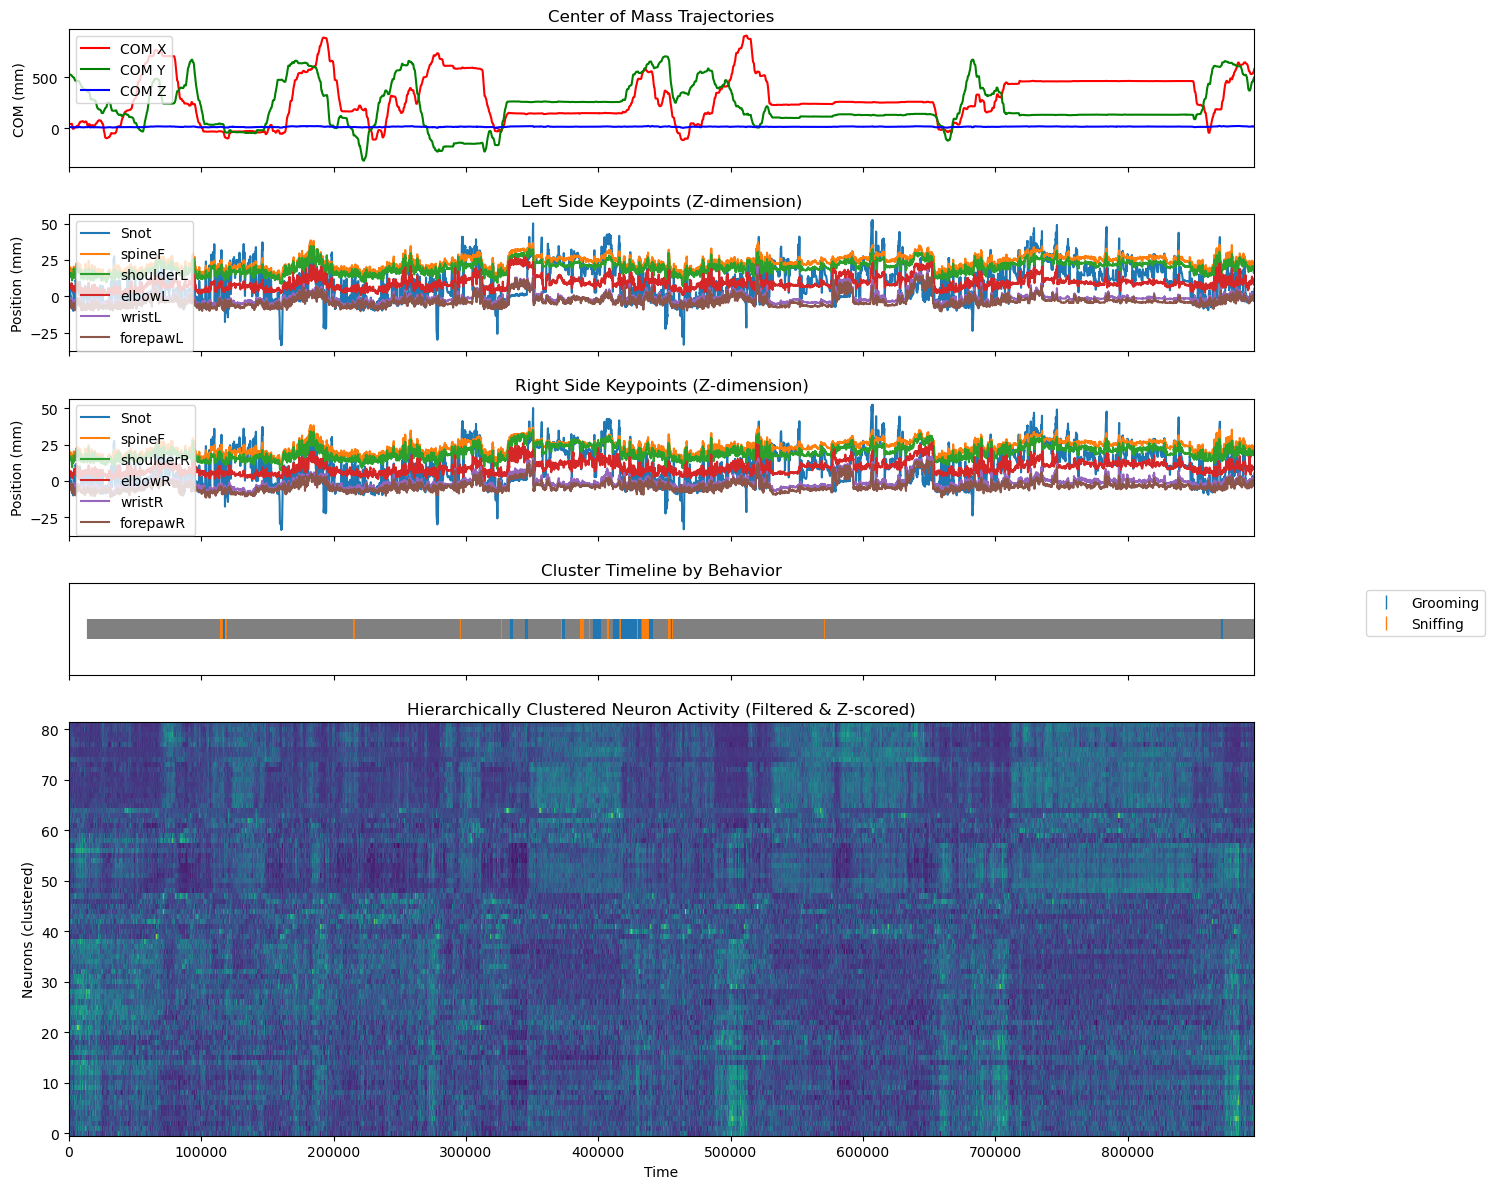

In [6]:
def main_plot_function(df_merged_with_dF_F, filtered_df, neuron_activity_normalized=None, filtered_neuron_columns=None):
    """
    Example main plotting function that:
      1) Plots COM (row 0)
      2) Plots left keypoints (row 1)
      3) Plots right keypoints (row 2)
      4) Plots the cluster timeline (row 3)
      5) Plots the Ca heatmap (rows 4-5)
    """
    df_new = df_merged_with_dF_F
    
    # Example location indices and labels
    location_indices_left = [3, 4, 12, 11, 10, 9]
    location_labels_left = {3: "Snot", 4: "spineF", 12: "shoulderL", 11: "elbowL", 10: "wristL", 9: "forepawL"}

    location_indices_right = [3, 4, 16, 15, 14, 13]
    location_labels_right = {3: "Snot", 4: "spineF", 16: "shoulderR", 15: "elbowR", 14: "wristR", 13: "forepawR"}

    # Assume time is the index
    time = df_new.index
    
    # --- Figure & GridSpec ---
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(nrows=6, ncols=1, height_ratios=[1.5, 1.5, 1.5, 1, 1, 3])
    # That gives us:
    #  row 0 => ax1 for COM
    #  row 1 => ax2 for Left Keypoints
    #  row 2 => ax3 for Right Keypoints
    #  row 3 => ax4 for cluster timeline
    #  row 4-5 => ax5 for Ca heatmap

    ###########################################
    # Top Plot (row 0): COM trajectories
    ###########################################
    ax1 = fig.add_subplot(gs[0, 0])
    if {'com_x', 'com_y', 'com_z'}.issubset(df_new.columns):
        ax1.plot(time, df_new['com_x'], color='red', label='COM X')
        ax1.plot(time, df_new['com_y'], color='green', label='COM Y')
        ax1.plot(time, df_new['com_z'], color='blue', label='COM Z')
        ax1.set_ylabel('COM (mm)')
        ax1.set_title('Center of Mass Trajectories')
        ax1.legend(loc='upper left')
    else:
        print("COM columns not found (com_x, com_y, com_z). Check your DataFrame.")
    ax1.tick_params(labelbottom=False)  # Remove x-axis labels

    ###########################################
    # Second Plot (row 1): Left Side Keypoints (Z-dim)
    ###########################################
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax2.set_title('Left Side Keypoints (Z-dimension)')
    for idx in location_indices_left:
        z_col = f'kp{idx}_z'
        if z_col in df_new.columns:
            ax2.plot(time, df_new[z_col], label=location_labels_left[idx])
        else:
            print(f"Warning: {z_col} not found for idx={idx}")
    ax2.set_ylabel('Position (mm)')
    ax2.legend(loc='upper left')
    ax2.tick_params(labelbottom=False)  # Remove x-axis labels

    ###########################################
    # Third Plot (row 2): Right Side Keypoints (Z-dim)
    ###########################################
    ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
    ax3.set_title('Right Side Keypoints (Z-dimension)')
    for idx in location_indices_right:
        z_col = f'kp{idx}_z'
        if z_col in df_new.columns:
            ax3.plot(time, df_new[z_col], label=location_labels_right[idx])
        else:
            print(f"Warning: {z_col} not found for idx={idx}")
    ax3.set_ylabel('Position (mm)')
    ax3.legend(loc='upper left')
    ax3.tick_params(labelbottom=False)  # Remove x-axis labels

    ###########################################
    # Fourth Plot (row 3): Cluster Timeline
    ###########################################
    ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)
    # Instead of calling a separate figure function, we use our timeline-on-axes function:
    plot_cluster_timeline_on_axes(ax4, filtered_df, time_index=df_new.index, behavior_labels=behavior_labels)
    # Remove x labels if you want the final plot to handle them:
    ax4.tick_params(labelbottom=False)

    ###########################################
    # Fifth Plot (rows 4-5): Ca heatmap
    ###########################################
    ax5 = fig.add_subplot(gs[4:6, 0], sharex=ax1)
    
    # Check if we have the neuron activity data
    if neuron_activity_normalized is not None and filtered_neuron_columns is not None:
        # Hierarchical clustering
        Z = linkage(neuron_activity_normalized, method='ward')
        neuron_order = leaves_list(Z)  # Leaves from dendrogram
        neuron_activity_ordered = neuron_activity_normalized[neuron_order, :]
        ordered_neuron_columns = [filtered_neuron_columns[i] for i in neuron_order]

        # Time axis
        time_values = time  # or np.arange(neuron_activity_ordered.shape[1])

        # Plot heatmap with pcolormesh
        neuron_indices = np.arange(len(neuron_activity_ordered))
        mesh = ax5.pcolormesh(
            time_values, neuron_indices, neuron_activity_ordered,
            cmap='viridis', shading='auto'
        )
        ax5.set_title('Hierarchically Clustered Neuron Activity (Filtered & Z-scored)')
        ax5.set_ylabel('Neurons (clustered)')
        ax5.set_xlabel('Time')
    else:
        print("Neuron activity data not found. Skipping heatmap plot.")
        ax5.text(0.5, 0.5, 'No neuron activity data available.',
                 transform=ax5.transAxes, ha='center', va='center')
        ax5.set_title('No Neuron Activity Plot')

    plt.tight_layout()
    plt.show()
# Example call:
main_plot_function(df_merged_with_dF_F, filtered_df,
                   neuron_activity_normalized=neuron_activity_normalized,
                   filtered_neuron_columns=filtered_neuron_columns)
